# Предсказание тональности и рейтинга отзывов (IMDB)

**Цель проекта:**
- Предсказать тональность отзыва о фильме (положительный/отрицательный)
- Предсказать рейтинг отзыва:
    *   рейтинг в диапазоне [1; 4] для отрицательного отзыва
    *   рейтинг в диапазоне [7; 10] для положительного отзыва

Модель построена на **bidirectional LSTM**, которая одновременно решает две задачи:
- Классификацию тональности
- Восстановление рейтинга отзыва на основе предсказанной тональности


**Результаты на тестовых данных:**
- Accuracy (для классификации тональности): 0.8734
- MAE (средняя абсолютная ошибка рейтинга): 1.9532



# Импорт библиотек и модулей

In [ ]:
!git clone https://github.com/Diank/IMDB_sentiment_rating.git

In [5]:
import sys

sys.path.append('../src') # путь к src

In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

import torch
from torch.utils.data import DataLoader
from torch import nn, optim

# импорт кода из src
from download_data import download_and_extract_imdb, load_reviews
from data import Preprocessor, IMDBDataset
from collate import collate_with_padding
from model import IMDB_Model
from train import train, evaluate, EarlyStopping, map_probability_to_rating
from utils import train_val_plots


In [8]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Загрузка данных

In [10]:
# скачиваем и распаковываем данные
dataset_path = download_and_extract_imdb(data_dir='data')

# загружаем данные в датафреймы
train_df = load_reviews(os.path.join(dataset_path, 'train'))
test_df = load_reviews(os.path.join(dataset_path, 'test'))

print(train_df.head())
print(test_df.head())

Скачивание датасета IMDB...
Датасет скачан.
Распаковка архива...
Распаковка завершена.
Содержимое папки aclImdb:
['test', 'imdb.vocab', 'imdbEr.txt', 'train', 'README']
                                              review  rating  label
0  Gandhi, the Great :<br /><br />Greatness in th...      10      1
1  Well, it definitely is unlike anything else di...       9      1
2  THE LADY FROM SHANGHAI is proof that the great...       9      1
3  You like to solve mysteries? You like complex ...       9      1
4  More TV movies ought to be made like this one....       9      1
                                              review  rating  label
0  This Bravo special is one of the most purely e...       9      1
1  America's next top model is a good show, it he...       8      1
2  It would be unwise to judge that that either n...       7      1
3  Mishima: A Life in Four Chapters is an art-hou...       9      1
4  The Merchant of Venice is a fantastic movie. I...       9      1


## Анализ данных (EDA)

In [11]:
train_df.head(2)

,review,rating,label
0,"Gandhi, the Great :<br /><br />Greatness in th...",10,1
1,"Well, it definitely is unlike anything else di...",9,1


In [12]:
train_df.info()  # пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  25000 non-null  object
 1   rating  25000 non-null  int64 
 2   label   25000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 586.1+ KB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  25000 non-null  object
 1   rating  25000 non-null  int64 
 2   label   25000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 586.1+ KB


In [14]:
train_df['label'].value_counts() # классы сбалансированы train

,count
label,
1,12500
0,12500


In [15]:
test_df['label'].value_counts() # классы сбалансированы test

,count
label,
1,12500
0,12500


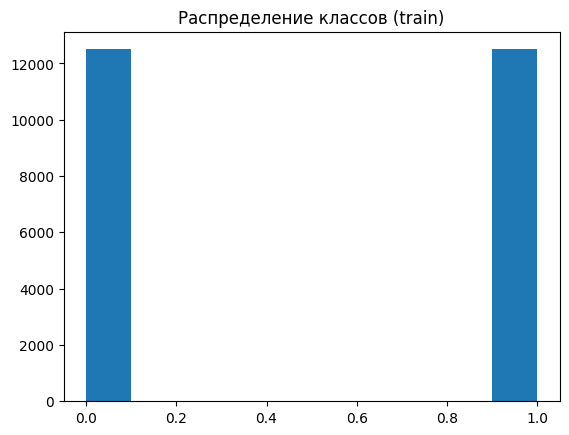

In [16]:
plt.hist(data=train_df, x='label')
plt.title('Распределение классов (train)')
plt.show()

In [17]:
train_df['rating'].unique()

array([10,  9,  8,  7,  4,  2,  1,  3])

In [18]:
train_df.groupby(by=['label']).agg(
    min_rating = ('rating', 'min'),
    max_rating = ('rating', 'max')
)

,min_rating,max_rating
label,,
0,1,4
1,7,10


In [19]:
# проверяем, что в тестовых данных

test_df.groupby(['label']).agg(
    min_rating = ('rating', 'min'),
    max_rating = ('rating', 'max')
)

,min_rating,max_rating
label,,
0,1,4
1,7,10


In [20]:
# видим, что для негативного отзыва (label 0) рейтинг фильма в отрезке [1, 4]
# для положительного отзыва (label 1) рейтинг фильма в отрезке [7, 10]

In [21]:
# средний рейтинг по каждому классу
train_df.groupby('label')['rating'].mean()

,rating
label,
0,2.21696
1,8.73848


In [22]:
# средний рейтинг по каждому классу
test_df.groupby('label')['rating'].mean()

,rating
label,
0,2.22312
1,8.80280


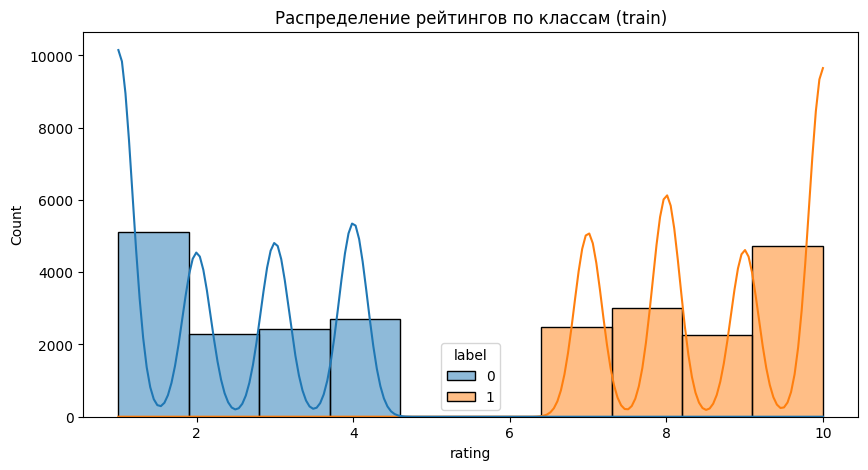

In [23]:
plt.figure(figsize=(10,5))
sns.histplot(data=train_df, x='rating', hue='label', bins=10, kde=True)
plt.title('Распределение рейтингов по классам (train)')
plt.show()

# Предобработка текста

In [24]:
VOCAB_SIZE = 10000
MAX_LEN = 500

# Инициализация препроцессора
preprocessor = Preprocessor(vocab_size=VOCAB_SIZE, max_len=MAX_LEN)
preprocessor.build_vocab(train_df['review'].tolist())

Размер словаря: 10004


#  Подготовка Dataset и DataLoader

In [25]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=RANDOM_STATE)

In [26]:
# Dataset
train_dataset = IMDBDataset(train_data, preprocessor)
val_dataset = IMDBDataset(val_data, preprocessor)
test_dataset = IMDBDataset(test_df, preprocessor)

# DataLoader
PAD_IDX = preprocessor.word2ind['<pad>']
collate_fn = partial(collate_with_padding, pad_id=PAD_IDX)

BATCH_SIZE = 128

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Построение модели и настройка обучения

In [27]:
# гиперпараметры модели
HIDDEN_DIM = 64
N_LAYERS = 1
DROPOUT = 0.5

# гиперпараметры обучения
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

N_EPOCHS = 30

ALPHA = 1.0    # вес для лосса классификации
BETA = 0.1     # вес для лосса регрессии

model = IMDB_Model(
    vocab_size=len(preprocessor.word2ind),
    hidden_dim=HIDDEN_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
).to(device)

criterion_sentiment = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
criterion_rating = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Scheduler и EarlyStopping
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

early_stopping = EarlyStopping(
    patience=3,
    mode='min',  # mode='min' for loss/MAE, 'max' for accuracy
    path='best_model.pt'
)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_maes, val_maes = [], []
best_val_loss = float('inf')  # для отслеживания лучшей модели


# Цикл обучения

In [30]:
# создаем папку для модели
os.makedirs('models', exist_ok=True)


for epoch in range(N_EPOCHS):
    # TRAIN
    train(
        model, train_dataloader, optimizer, criterion_sentiment, criterion_rating,
        ALPHA, BETA, epoch, device
    )

    # TRAIN METRICS
    train_loss, train_acc, train_mae = evaluate(
        model, train_dataloader, criterion_sentiment, criterion_rating,
        ALPHA, BETA, device
    )
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, MAE: {train_mae:.4f}")

    # VAL METRICS
    val_loss, val_acc, val_mae = evaluate(
        model, val_dataloader, criterion_sentiment, criterion_rating,
        ALPHA, BETA, device
    )
    print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, MAE: {val_mae:.4f}\n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # сохраняем лучшую модель
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'models/best_model.pt')
        print('Best model saved!')

    # early_stopping
    early_stopping(val_mae, model)
    if early_stopping.early_stop:
        print('Early stopping triggered')
        break

    # scheduler
    scheduler.step(val_loss)
    print(f"After scheduler step: {optimizer.param_groups[0]['lr']:.6f}\n")


Training epoch: 1: 100%|██████████| 157/157 [00:37<00:00,  4.17it/s]


Loss sentiment: 0.1904, Loss rating: 1.9321, Total: 0.3836
Train Loss: 0.3768, Accuracy: 0.9242, MAE: 1.7478
Val Loss: 0.5198, Accuracy: 0.8672, MAE: 1.9992

Best model saved!
Saving model with score: 1.9992
After scheduler step: 0.001000



Training epoch: 2: 100%|██████████| 157/157 [00:37<00:00,  4.17it/s]


Loss sentiment: 0.2377, Loss rating: 1.7062, Total: 0.4083
Train Loss: 0.3488, Accuracy: 0.9321, MAE: 1.7210
Val Loss: 0.5237, Accuracy: 0.8660, MAE: 2.0041

EarlyStopping counter: 1 out of 3
After scheduler step: 0.001000



Training epoch: 3: 100%|██████████| 157/157 [00:46<00:00,  3.40it/s]


Loss sentiment: 0.2373, Loss rating: 1.9753, Total: 0.4349
Train Loss: 0.3007, Accuracy: 0.9526, MAE: 1.6657
Val Loss: 0.5321, Accuracy: 0.8722, MAE: 2.0239

EarlyStopping counter: 2 out of 3
After scheduler step: 0.001000



Training epoch: 4: 100%|██████████| 157/157 [00:37<00:00,  4.15it/s]


Loss sentiment: 0.1872, Loss rating: 2.3018, Total: 0.4174
Train Loss: 0.2700, Accuracy: 0.9655, MAE: 1.6159
Val Loss: 0.5422, Accuracy: 0.8724, MAE: 2.0376

EarlyStopping counter: 3 out of 3
Early stopping triggered


# Графики метрик

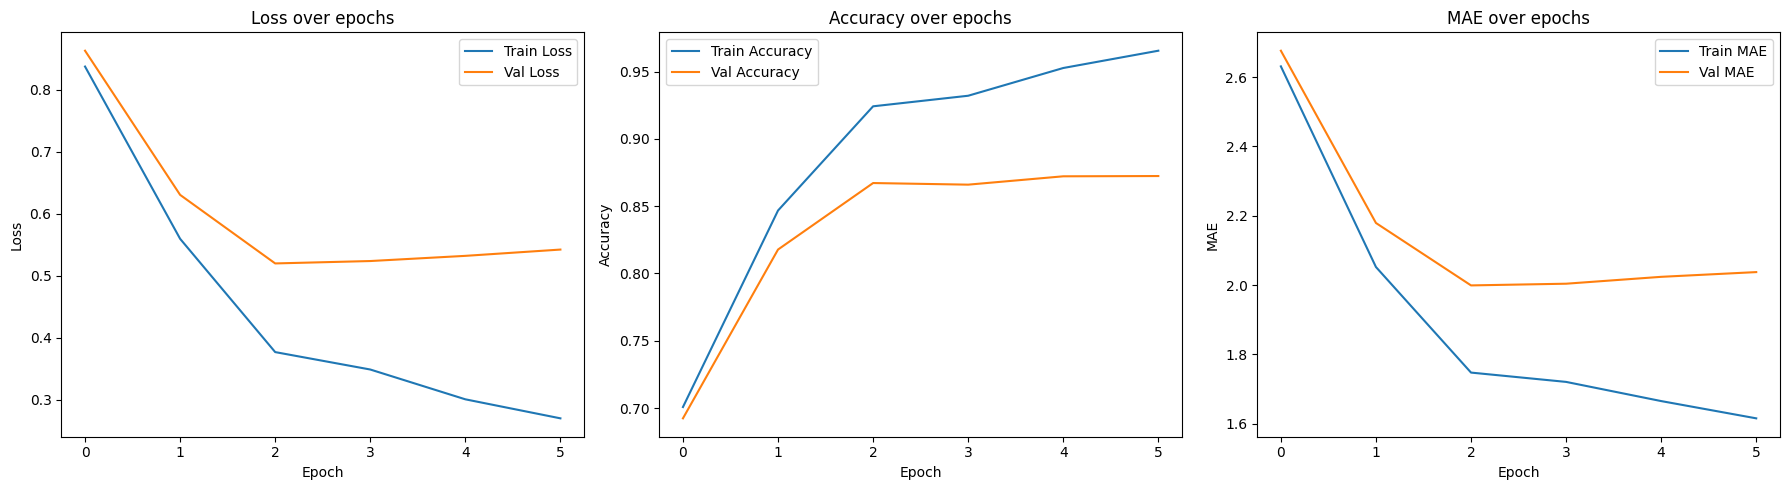

In [31]:
train_val_plots(train_losses, val_losses, train_accuracies, val_accuracies, train_maes, val_maes)

## Анализ результатов обучения

На графиках показано поведение метрик обучения:

- **Loss**: Видно, что модель хорошо обучается, но начиная с 3-й эпохи наблюдается небольшой рост лосса на валидации — начинается переобучение.
- **Accuracy**: Высокая точность на обучении (около 0.97) и хорошая на валидации (около 0.87), но разница между ними тоже может говорить о переобучении.
- **MAE**: Ошибка предсказания рейтинга снижается, но начинает расти после 3-й эпохи — модель теряет обобщающую способность.

Для улучшения модели можно:
- лучше подобрать гиперпараметры
- изменить архитектуру модели


# Финальная оценка на тесте

In [32]:
# загружаем лучшую модель
model.load_state_dict(torch.load('models/best_model.pt'))

<All keys matched successfully>

In [33]:
test_loss, test_acc, test_mae = evaluate(
    model, test_dataloader, criterion_sentiment, criterion_rating,
    ALPHA, BETA, device
    )
print(f'Test Loss: {test_loss:.4f}')
print(f'Accuracy: {test_acc:.4f}')
print(f'MAE: {test_mae:.4f}\n')

Test Loss: 0.4924
Accuracy: 0.8734
MAE: 1.9532



# Пример предсказания на новом отзыве

In [40]:
import textwrap

example = test_df.iloc[10]['review']
wrapped_review = textwrap.fill(example, width=100) # обертка для переноса строк

tokens = [preprocessor.word2ind['<bos>']] + [
    preprocessor.word2ind.get(token, preprocessor.word2ind['<unk>'])
    for token in preprocessor._tokenize(example)
] + [preprocessor.word2ind['<eos>']]

tokens_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()

with torch.no_grad():
    sentiment_logits = model(tokens_tensor)
    probs = torch.softmax(sentiment_logits, dim=1).squeeze(1)

    sentiment = torch.argmax(probs, dim=1).item()
    rating_pred = map_probability_to_rating(probs)

print(f"Отзыв о фильме:\n{wrapped_review}\n")
print(f"Предсказанная тональность: {'Положительный отзыв' if sentiment == 1 else 'Отрицательный отзыв'}")
print(f"Предсказанный рейтинг: {rating_pred[0]:.4f}")


Отзыв о фильме:
Its a spoof, its an intelligent comedy, it has some a pathetic action and choreography (and mind it,
it is intentional), good hummable songs, good performances by the entire cast, brilliant by Amir,
Salman and Paresh and over all an script which is so rare in Indian cinema that too in comedy (watch
David Dhawan, Harmesh Malhotra etc). Story is of two wastrels whose only aim is to get rich and
famous by any which ways. They come across one such way when they find out that a rich NRI is coming
India to get married. Rest of the story is about oneupmanship and how these wastrels try to out wit
each other. Entire cast is perfectly cast right from Deven Verma till Viju Khote. Songs are rightly
placed and are funny. Surprise package is Salman who acts with perfect timing and this particular
act gave him his style of comedy.<br /><br />All an all a fum film which you should not ignore if
you like and watch Indian Cinema.

Предсказанная тональность: Положительный отзыв
Предсказа